<h1>7 Park SQL Exercises</h1>

<p>The team explored BigQuery and ran some queries in the console to become familiar with BigQuery.  After studying the documentation further, we were able to learn about the Jupyter Notebook package for BigQuery and we use it here to answer the SQL questions</p

In [88]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./adept-comfort-307720-db5f8ca3ee46.json"
client = bigquery.Client()
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


<h1>SQL Question 1</h1>

In [89]:
%%bigquery state_2018_5yr
SELECT *
FROM
    `bigquery-public-data.census_bureau_acs.state_2018_5yr`

Downloading: 100%|██████████| 52/52 [00:01<00:00, 27.12rows/s]


<h2>2018 5 year Weighted Mean of per capita US Income by population </h2>
<p> Methodology: (1) multiply per capita income for each state with population of that state
(2) sum above for all states and divide with total population of the United States</p>

In [90]:
us_pop = state_2018_5yr['total_pop'].sum()
average_income =  ((state_2018_5yr['income_per_capita']*state_2018_5yr['total_pop']).sum())/us_pop
print(f'The average income per capita in the US was ${round(average_income,2)}')

The average income per capita in the US was $32411.26


<h2>2018 5 year Weighted Median of US Income by household aggregations</h2>
<p> Methodology: (1) add up households in each income bin (2) calculate midpoint of households by summing up all US households and dividing by 2 (3) find household midpoint among the bins and (4) use the max and min values of each bin</p>

In [121]:
#Using income bins for our median calculations
bins_ = ['income_less_10000','income_10000_14999', 'income_15000_19999',
         'income_20000_24999','income_25000_29999','income_30000_34999',
         'income_35000_39999','income_40000_44999','income_45000_49999',
         'income_50000_59999','income_60000_74999','income_75000_99999',
         'income_100000_124999','income_125000_149999','income_150000_199999',
         'income_200000_or_more']
binMiddle = [5000,12500,17500,22500,27500,32500,37500,42500,47500,55000,
            67500,87500,112500,137500,175000,300000]
binRangeLow = [0,10000,15000,20000,25000,30000,35000,40000,45000,50000,60000,
               75000,100000,125000,150000,200000]
binRangeHigh = [10000,14999,19999,24999,29999,34999,39999,44999,49999,59999,
                74999,99999,124999,149999,199999,350000]


def medianHouseholdIncome(householdBins,midPointHouseholds):   
    medianHouseholds = 0
    for idx,households in enumerate(householdBins):
            prevMedianHouseholds = medianHouseholds
            medianHouseholds += households
            if medianHouseholds >= midPointHouseholds:
                binInterval = binRangeHigh[idx] - binRangeLow[idx]
                return binRangeLow[idx]+((midPointHouseholds-prevMedianHouseholds)/households)*binInterval

usHouseholdBins=[]
for bin_ in bins_:
        usHouseholdBins.append(state_2018_5yr[bin_].sum())
midPointUSHouseholds = state_2018_5yr['households'].sum()/2
print(f'The median household income in the US was: ${round(medianHouseholdIncome(usHouseholdBins,midPointUSHouseholds),2)}')

The median household income in the US was: $59782.9


<h2>2018 5 year United States Income by households Bar graph and skewness</h2>

The number of households in each income bin is a useful representation of the wealth distribution in the US

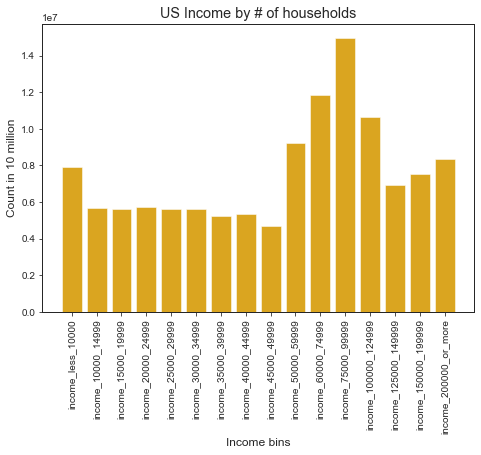

In [92]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(bins_,usHouseholdBins,color="goldenrod")
plt.xticks(rotation=90)
ax.set_title("US Income by # of households")
ax.set_xlabel("Income bins")
ax.set_ylabel("Count in 10 million")
plt.show()

In [93]:
bins_df = pd.DataFrame(np.column_stack([bins_, binMiddle]), columns=['income_bin', 'bin_avg_income'])
bins_df['bin_avg_income']= bins_df['bin_avg_income'].astype(int)

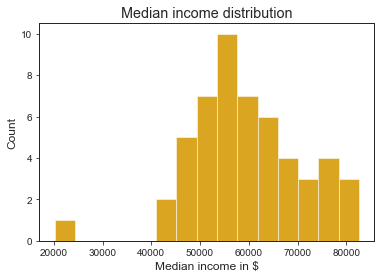

In [94]:
plt.hist(state_2018_5yr['median_income'], bins=15, color = "goldenrod")
plt.title('Median income distribution')
plt.xlabel("Median income in $")
plt.ylabel("Count");

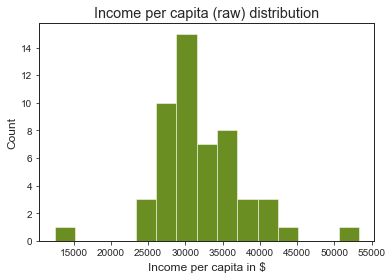

In [95]:
plt.hist(state_2018_5yr['income_per_capita'], bins=15 , color = 'olivedrab')
plt.xlabel("Income per capita in $")
plt.title('Income per capita (raw) distribution')
plt.ylabel("Count");

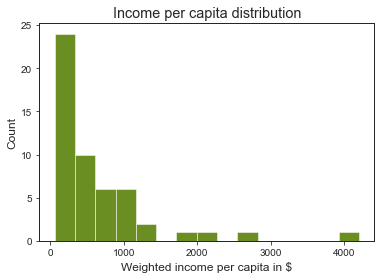

In [96]:
state_2018_5yr['weigh_inc_per_capita'] = ((state_2018_5yr['income_per_capita']*
                                           state_2018_5yr['total_pop']))/(state_2018_5yr['total_pop'].sum())

plt.hist(state_2018_5yr['weigh_inc_per_capita'], bins=15, color = 'olivedrab')
plt.xlabel("Weighted income per capita in $")
plt.ylabel("Count")
plt.title('Income per capita distribution');

In [97]:
print(f"The skewnes of the income in the US was {round(state_2018_5yr['weigh_inc_per_capita'].skew(), 2)}")

The skewnes of the income in the US was 2.85


<h2>2018 5 year United States Income Percentile ranking</h1>

In [98]:
#define the percentiles
perc_breakdowns=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]


#calculate the income of each percentile based on the info from income bins
def calc_household_perc_rank(householdBins):
    totalHouseholds = sum(householdBins)
    cumHouseholds = []
    binSum = 0
    incomebin = []
    for binVal in householdBins:
        binSum += binVal
        cumHouseholds.append(binSum)
    idx = 0
    for perc in perc_breakdowns:
        householdVal = totalHouseholds*perc
        while cumHouseholds[idx]<householdVal:
            idx += 1
        binInterval = binRangeHigh[idx]-binRangeLow[idx]
        incomebin.append(binRangeLow[idx]+(
            ((householdVal-cumHouseholds[idx-1])/householdBins[idx]*binInterval)))
    return incomebin

In [120]:
tx_household_bins = state_2018_5yr[state_2018_5yr['geo_id']=='48'][bins_].values.tolist()[0]
ca_household_bins = state_2018_5yr[state_2018_5yr['geo_id']=='06'][bins_].values.tolist()[0]
ny_household_bins = state_2018_5yr[state_2018_5yr['geo_id']=='36'][bins_].values.tolist()[0]
fl_household_bins = state_2018_5yr[state_2018_5yr['geo_id']=='12'][bins_].values.tolist()[0]

percentile_df = {'percentiles' : [str(round(val*100))+'%' for val in perc_breakdowns],
                 'us' : calc_household_perc_rank(usHouseholdBins),
                 'texas' : calc_household_perc_rank(tx_household_bins),
                 'california' : calc_household_perc_rank(ca_household_bins),
                 'ny': calc_household_perc_rank(ny_household_bins),
                 'fl': calc_household_perc_rank(fl_household_bins)}

import plotly.graph_objects as go
import plotly.offline as pyo

pyo.init_notebook_mode()


fig = go.Figure(data=[
    go.Bar(name='USA', x=percentile_df['percentiles'], y=percentile_df['us']),
    go.Bar(name='Texas', x=percentile_df['percentiles'], y=percentile_df['texas']),
    go.Bar(name='California', x=percentile_df['percentiles'], y=percentile_df['california']),
    go.Bar(name='New York', x=percentile_df['percentiles'], y=percentile_df['ny']),
    go.Bar(name='Florida', x=percentile_df['percentiles'], y=percentile_df['fl'])])

# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(
    title="Median income in household percentiles",
    xaxis_title="Household percentiles",
    yaxis_title="Median income",
    plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(colorscale_sequential= 'portland')
fig.show()             

Join tables in SQL to practice the language and perform calculations and graphs in the JupyterNotebook

In [100]:
%%bigquery state_7yrs

SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2012_1yr`
UNION ALL
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2013_1yr`
UNION ALL
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2014_1yr`
UNION ALL 
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2015_1yr`
UNION ALL 
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2016_1yr`
UNION ALL 
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2017_1yr`
UNION ALL 
SELECT geo_id, 
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2018_1yr`
ORDER BY do_date;

Downloading: 100%|██████████| 364/364 [00:01<00:00, 201.69rows/s]


<h2>2013-2018 Income per capita mean growth rate</h1>

In [101]:
%%bigquery avg_income_state_7yrs
SELECT 
do_date,
sum(income_per_capita*total_pop)/sum(total_pop)
FROM
(SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2012_1yr`
UNION ALL
    SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2013_1yr`
UNION ALL
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2014_1yr`
UNION ALL 
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2015_1yr`
UNION ALL 
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2016_1yr`
UNION ALL 
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2017_1yr`
UNION ALL 
SELECT geo_id, 
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2018_1yr`
ORDER BY do_date ASC)
GROUP BY do_date
ORDER BY do_date ASC


Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.21rows/s]


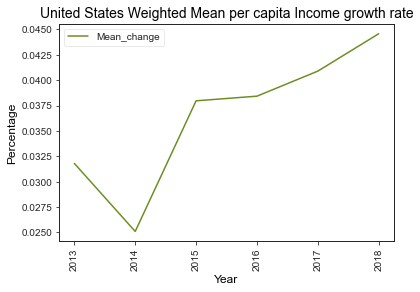

In [102]:
avg_income_state_7yrs.columns=["Year","mean"]
avg_income_state_7yrs['Mean_change']=avg_income_state_7yrs['mean'].pct_change()
avg_income_state_7yrs.drop([0],inplace=True)
avg_income_state_7yrs.drop(["mean"],inplace=True,axis=1)

avg_income_state_7yrs.plot(x="Year",y="Mean_change",color = 'olivedrab')
plt.title('United States Weighted Mean per capita Income growth rate', color='black',fontsize='14')
plt.xlabel("Year", color='black',fontsize='12')
plt.ylabel("Percentage", color='black',fontsize='12')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show()

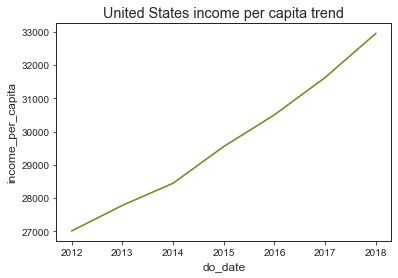

In [103]:
by_year_df = state_7yrs.groupby('do_date', as_index = False).agg('mean')
by_year_df = pd.melt(by_year_df, id_vars= ['total_pop', 'households','median_income',
                                           'income_per_capita','do_date'],
                     value_vars = bins_, var_name = "income_bin", value_name ='households_in_bin')


sns.lineplot(data = by_year_df, x='do_date', y='income_per_capita', color = 'olivedrab')
plt.title('United States income per capita trend');

<h1>2013-2018 Household Income median growth rate</h1>

In [104]:
def getMedian(sums_row):
    return (medianHouseholdIncome(sums_row[bins_].values,sums_row["midPointHouseholds"]))

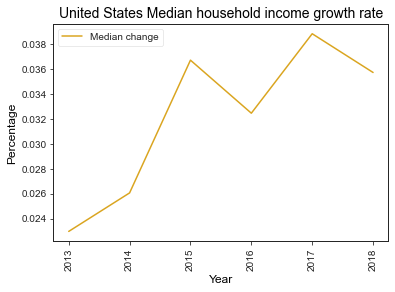

In [105]:
sums_by_year=state_7yrs.groupby("do_date").agg(['sum']).reset_index()
sums_by_year.columns = sums_by_year.columns.get_level_values(0)
sums_by_year["midPointHouseholds"]=sums_by_year["households"]/2
sums_by_year["median"]=sums_by_year.apply(lambda x: getMedian(x),axis=1)
sums_by_year['median_change']=sums_by_year["median"].pct_change()
median_household_income_by_year=pd.DataFrame({'Year':sums_by_year["do_date"],'Median change':sums_by_year["median_change"]})
median_household_income_by_year.drop([0],inplace=True)

median_household_income_by_year.plot(x="Year",y="Median change", color = "goldenrod")
plt.title('United States Median household income growth rate', color='black',fontsize='14')
plt.xlabel("Year", color='black',fontsize='12')
plt.ylabel("Percentage", color='black',fontsize='12')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show()

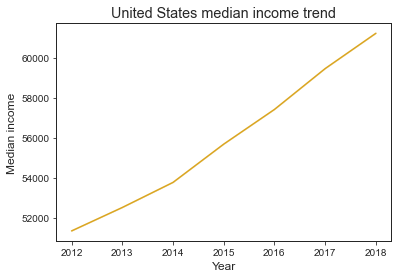

In [106]:
sns.lineplot(data = by_year_df, x='do_date', y='median_income', color = "goldenrod")
plt.xlabel('Year')
plt.ylabel('Median income')
plt.title('United States median income trend');

<h1>2013-2018 United States household income aggregation bar chart</h1>

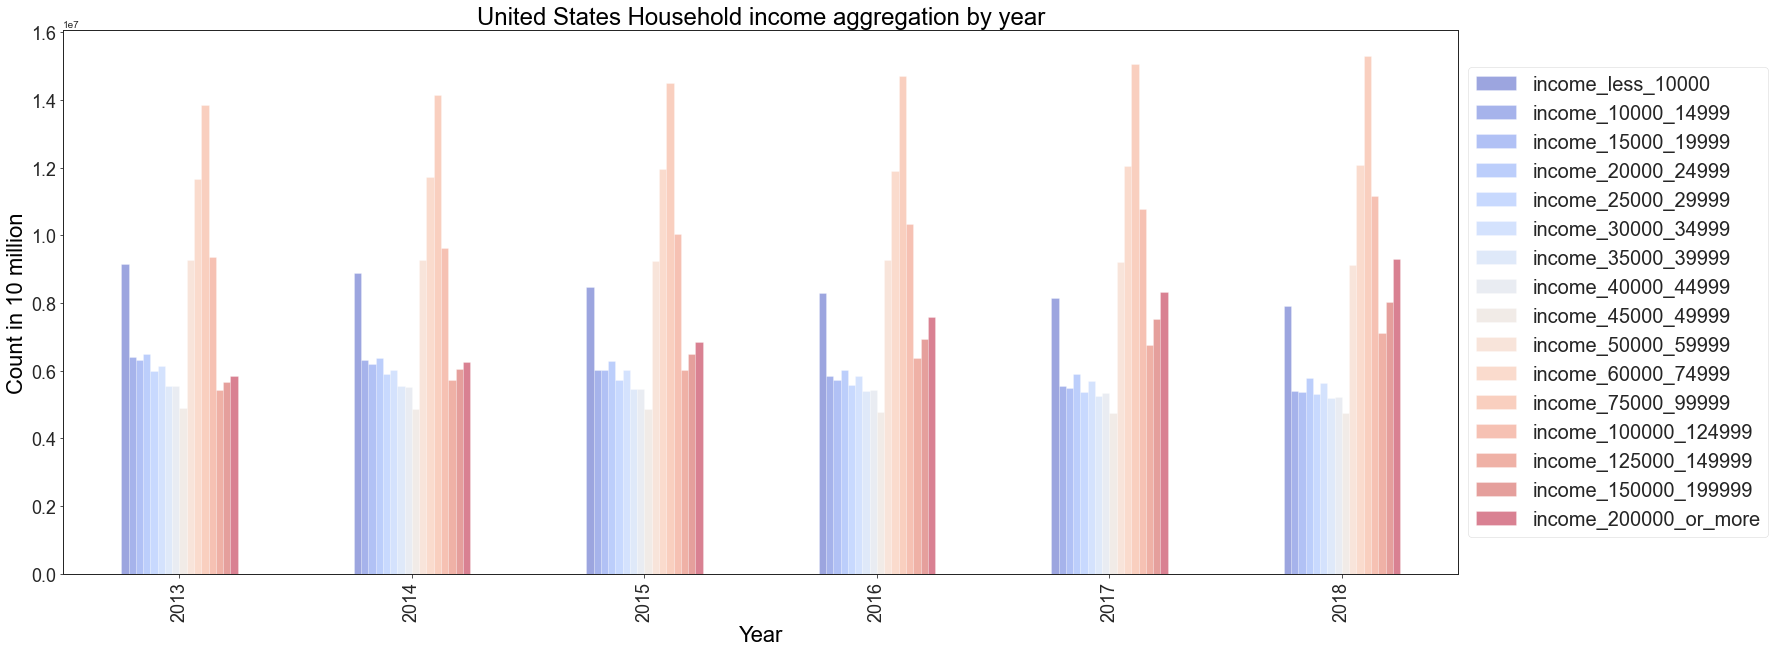

In [107]:
#median income trends for the US
sums_by_year_agg_income = sums_by_year[["do_date"]+bins_]
sums_by_year_agg_income = sums_by_year_agg_income[sums_by_year_agg_income["do_date"]!="2012"]

sums_by_year_agg_income.plot.bar(x="do_date",figsize=(25,10),
                                 alpha=0.5,cmap='coolwarm')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)
plt.title('United States Household income aggregation by year', color='black',fontsize='24')
plt.xlabel("Year", color='black',fontsize='22')
plt.ylabel("Count in 10 million", color='black',fontsize='22')
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.show()

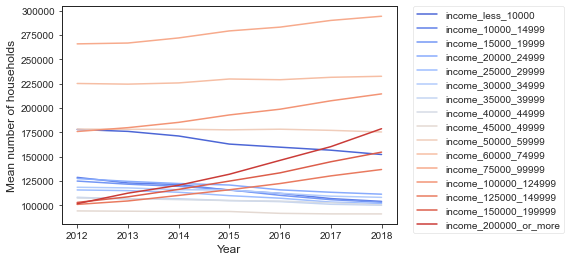

In [108]:
sns.lineplot(data = by_year_df, x='do_date', y='households_in_bin',
             hue = 'income_bin', palette = "coolwarm")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Year')
plt.ylabel('Mean number of households');

<h1>2013-2018 NY, CA, TX, FL household income aggregation bar chart</h1>

In [109]:
sums_by_year_geo_id=state_7yrs.groupby(["do_date","geo_id"]).agg(['sum']).reset_index()
sums_by_year_geo_id.columns = sums_by_year_geo_id.columns.get_level_values(0)
sums_by_year_geo_id=sums_by_year_geo_id[sums_by_year_geo_id["do_date"]!="2012"]
sums_by_year_geo_id_NY=sums_by_year_geo_id[sums_by_year_geo_id["geo_id"]=="36"]
sums_by_year_geo_id_CA=sums_by_year_geo_id[sums_by_year_geo_id["geo_id"]=="06"]
sums_by_year_geo_id_TX=sums_by_year_geo_id[sums_by_year_geo_id["geo_id"]=="48"]
sums_by_year_geo_id_FL=sums_by_year_geo_id[sums_by_year_geo_id["geo_id"]=="12"]

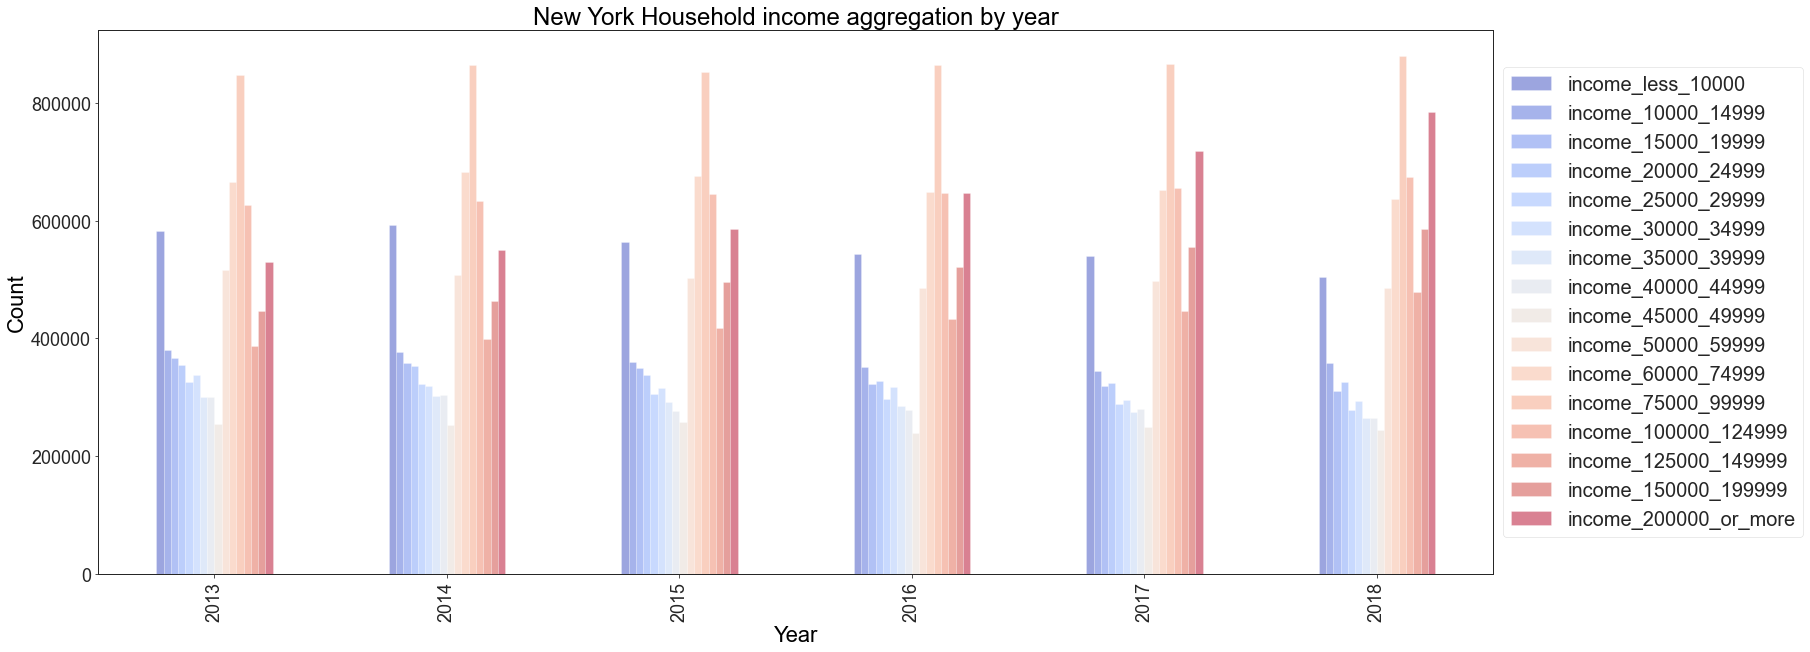

In [110]:
#median income trends for New York
sums_by_year_agg_income_NY=sums_by_year_geo_id_NY[["do_date"]+bins_]
sums_by_year_agg_income_NY.plot.bar(x="do_date",figsize=(25,10),
                                    alpha=0.5,cmap='coolwarm')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)
plt.title('New York Household income aggregation by year', color='black',fontsize='24')
plt.xlabel("Year", color='black',fontsize='22')
plt.ylabel("Count", color='black',fontsize='22')
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.show()

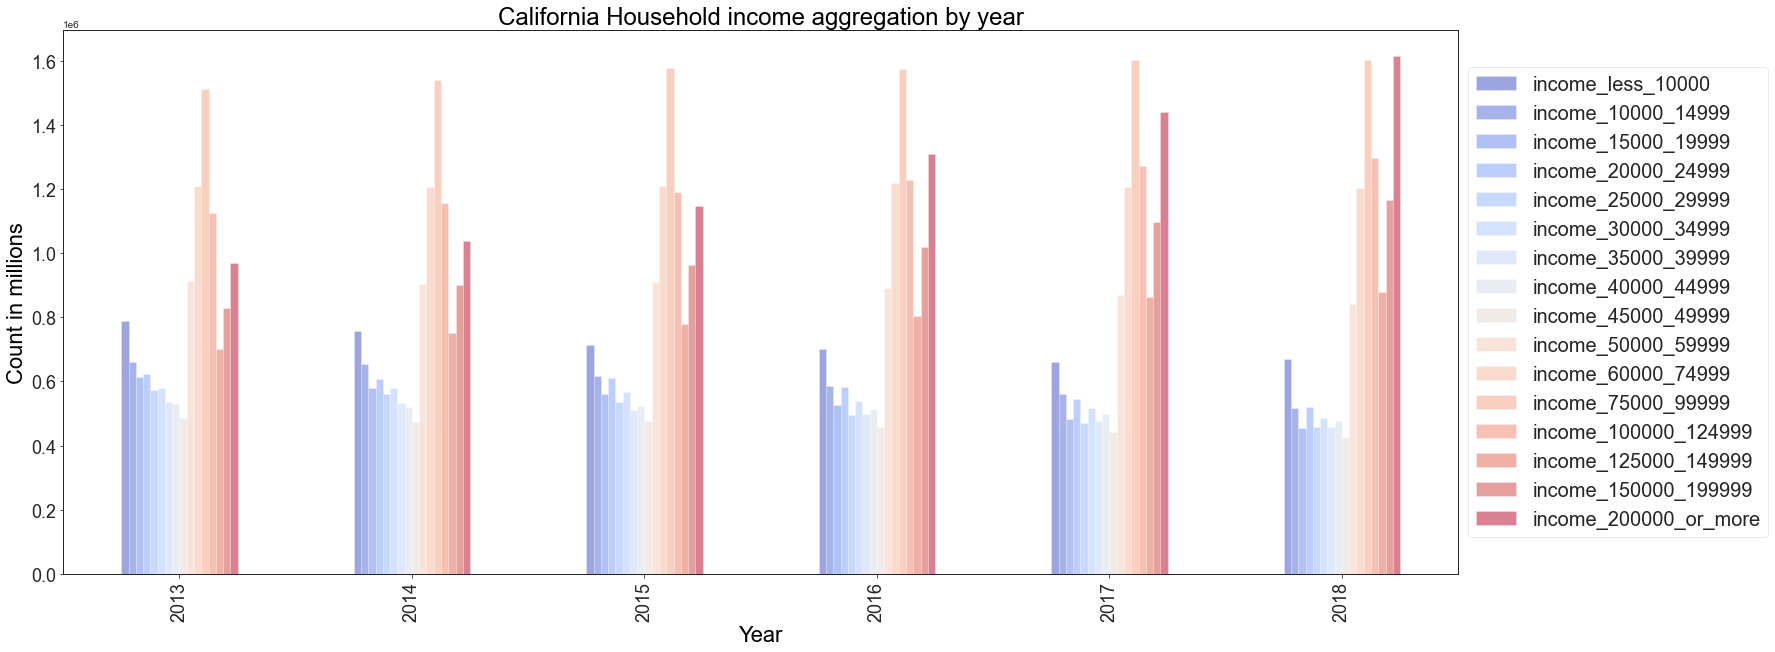

In [111]:
#median income trends for California
sums_by_year_agg_income_CA = sums_by_year_geo_id_CA[["do_date"]+bins_]
sums_by_year_agg_income_CA.plot.bar(x="do_date",figsize=(25,10),
                                    alpha=0.5,cmap='coolwarm')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)
plt.title('California Household income aggregation by year', color='black',fontsize='24')
plt.xlabel("Year", color='black',fontsize='22')
plt.ylabel("Count in millions", color='black',fontsize='22')
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.show()

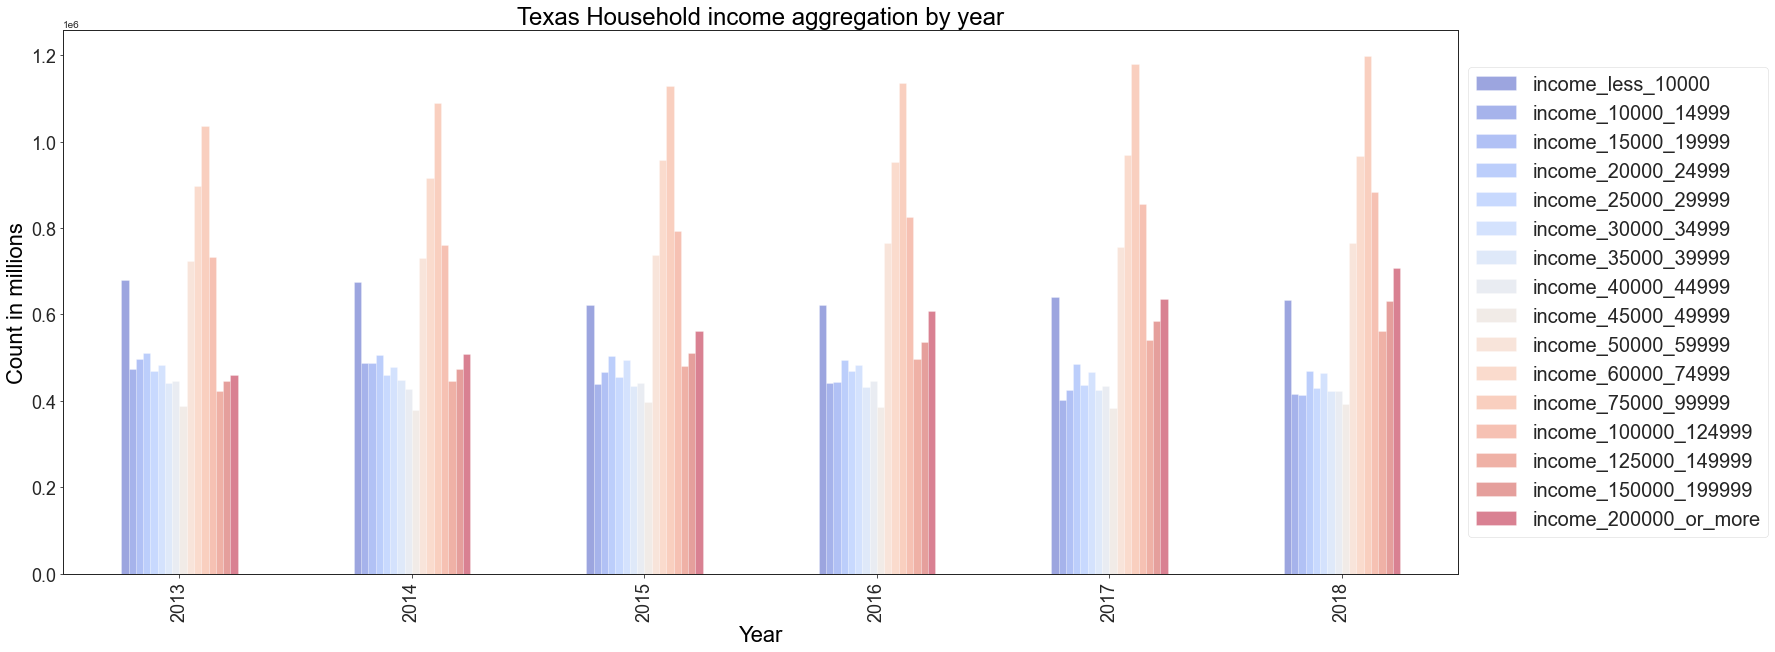

In [112]:
#median income trends for Texas
sums_by_year_agg_income_TX = sums_by_year_geo_id_TX[["do_date"]+bins_]
sums_by_year_agg_income_TX.plot.bar(x="do_date",figsize=(25,10),
                                    alpha=0.5,cmap='coolwarm')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)
plt.title('Texas Household income aggregation by year', color='black',fontsize='24')
plt.xlabel("Year", color='black',fontsize='22')
plt.ylabel("Count in millions", color='black',fontsize='22')
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.show()

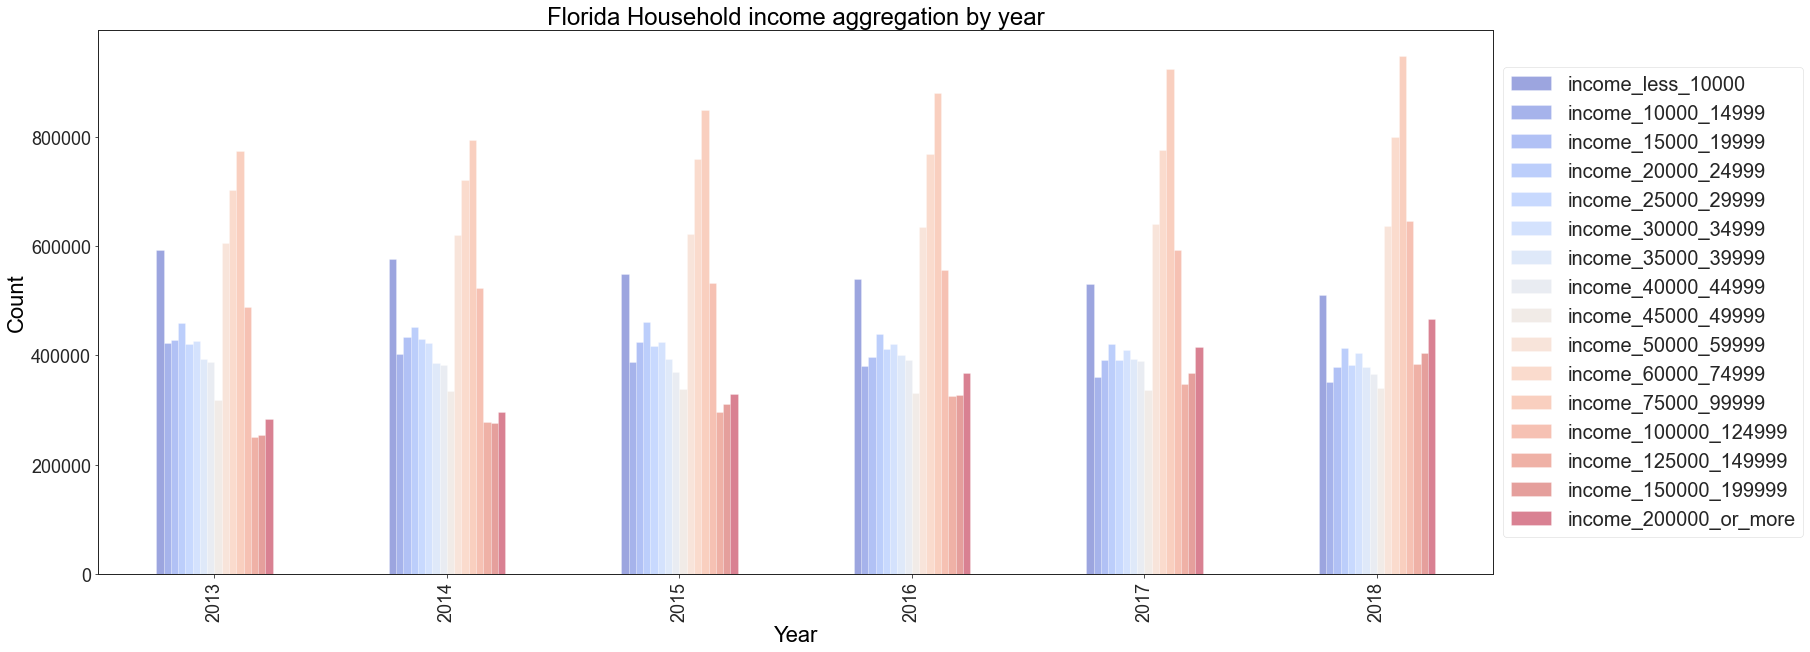

In [113]:
#median income trends for Florida
sums_by_year_agg_income_NY = sums_by_year_geo_id_FL[["do_date"]+bins_]
sums_by_year_agg_income_NY.plot.bar(x="do_date",figsize=(25,10),
                                    alpha=0.5,cmap='coolwarm')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)
plt.title('Florida Household income aggregation by year', color='black',fontsize='24')
plt.xlabel("Year", color='black',fontsize='22')
plt.ylabel("Count", color='black',fontsize='22')
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.show()